# Lesson 9: Final Decisions

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2020_Spring/notebooks/09_Final_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Wiener First Passage of Time
- Posterior Exploration


## Example: Speed--Accuracy trade-off

- Sometimes we have to make fast decisions
- Other times we just need to be as accurate as possible.

## *ONLY* if on Google Colab

In [ ]:
# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git


In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2020_Spring/notebooks/decision_data.csv

In [ ]:
# to retrieve the wfpt model
!wget https://raw.githubusercontent.com/compmem/QuantCog/2020_Spring/notebooks/wfpt.py

In [ ]:
# to install more libraries
!pip install arviz

## Load and process the data

In [52]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

from ipywidgets import interact, fixed

import arviz as az

from RunDEMC.density import kdensity
from RunDEMC import Model, Param, dists, calc_bpic, joint_plot
from RunDEMC.io import arviz_dict

from wfpt import wfpt_like, wfpt_gen



In [2]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)
dat = dat[dat.cond != 'Neutral']
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

,correct,rt,cond,log_rt,rt_acc
3,1,0.4784,Accuracy,-0.737308,0.4784
4,1,0.4300,Accuracy,-0.843970,0.4300
5,1,0.4486,Accuracy,-0.801624,0.4486
6,1,0.3991,Speed,-0.918543,0.3991
8,1,0.4393,Accuracy,-0.822573,0.4393


## Wiener First Passage of Time (WFPT)

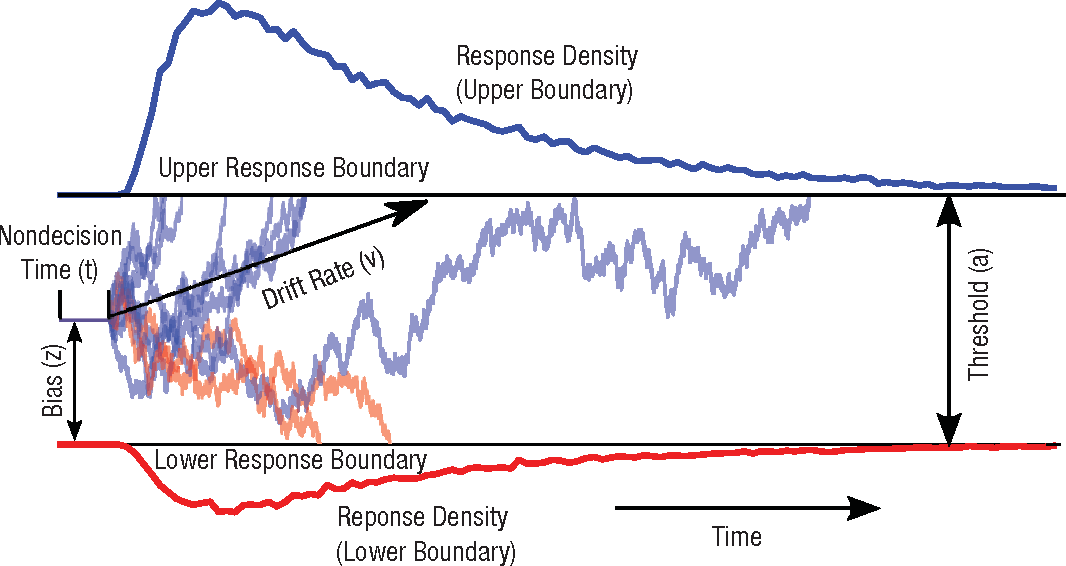


In [5]:
# set up the sim
nsims = 5000
cond='Accuracy'

# normed histogram
def dhist(dat, nvals, alpha=.3, color='b'):
    p,b = np.histogram(dat, bins='auto', density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nvals
    return plt.bar(b[1:]-w, p, width=w, alpha=.3, color=color)

# normed pdf
xvals = np.linspace(0.0,2.0,1000)

# put it all together
@interact(cond=['Accuracy', 'Speed'],
          v_mean=(-5,5.0,0.05),
          v_std=(0.0,5.0,0.05),
          a=(0.0,5.0,.05),
          w_mode=(0.0,1.0,.05),
          w_std=(0.0,1.0,.02),
          t0=(0.0,1.0,.02),
          S=fixed(1.0),
          nsamp=fixed(2000),
          err=fixed(.0001)
          )
def run_wfpt(cond, v_mean=1.75, a=1.5, w_mode=.5, w_std=0.0,
             v_std=0.0, t0=0.0, nsamp=5000, err=.0001):

    ndat = (dat['cond']==cond).sum()
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    likes = wfpt_like(np.ones(len(xvals))*2, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='b', lw=2.)
    
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    likes = wfpt_like(np.ones(len(xvals))*1, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='r', lw=2.)
    #ylim(0,5.0)
    plt.xlim(0,2.0)

interactive(children=(Dropdown(description='cond', options=('Accuracy', 'Speed'), value='Accuracy'), FloatSlid…

## Using computers to test hypotheses

In [21]:
# grab the beh data of interest
choices_A = np.array(dat[(dat['cond']=='Accuracy')]['correct']+1)
rts_A = np.array(dat[(dat['cond']=='Accuracy')]['rt'])
choices_S = np.array(dat[(dat['cond']=='Speed')]['correct']+1)
rts_S = np.array(dat[(dat['cond']=='Speed')]['rt'])
min_rt = dat.rt.min()

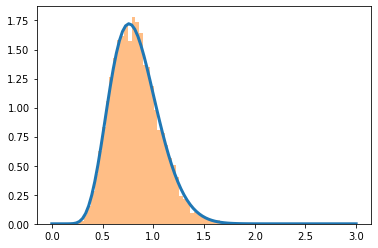

In [22]:
# explore the logit normal transformation
def logitnorm(x, mu=0.0, sigma=1.4):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-((np.log(x/(1-x))-mu)**2)/(2*sigma**2)) * (1/(x*(1-x)))

mu = -1.0
std = .4
lower = 0.0
upper = 3.0
xrng = (upper - lower)
xvals = np.linspace(0.0001, .9999, 100)
plt.plot(xvals*xrng + lower, logitnorm(xvals, mu, std)/xrng, lw=3)
plt.hist(dists.invlogit(dists.normal(mu, std).rvs(5000))*xrng + lower, bins='auto', 
         alpha=.5, density=True);

In [41]:
# Test change in threshold

# set up the params
params = [Param(name='v_A', prior=dists.normal(0., 2.)),
          Param(name='v_S', prior=dists.normal(0., 2.)),
          Param(name='w', prior=dists.normal(0, 1.4), transform=dists.invlogit),
          Param(name='a_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='a_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]
param_names = [p.name for p in params]

# define the likelihood function
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first Accuracy
        likes_A = wfpt_like(choices_A, rts_A, 
                            v_mean=p['v_A'], v_std=0.0, a=p['a_A'], 
                            w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                            nsamp=1000)
        likes[i] += np.log(likes_A).sum()
        if likes[i] == -np.inf:
            continue
            
        # then Speed
        likes_S = wfpt_like(choices_S, rts_S, 
                            v_mean=p['v_S'], v_std=0.0, a=p['a_S'], 
                            w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                            nsamp=1000)
        likes[i] += np.log(likes_S).sum()

    return likes
        
# make the model
m = Model('all', params=params,
          like_fun=like_fun,
          pop_parallel=True,
          #like_args=(param_names,),
          #purify_every=5,
          verbose=True)


In [42]:
# do some burnin
times = m.sample(100, burnin=True)

Initializing: 60(60) 1(1) Iterations (100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 


In [43]:
# sample from the posterior
times = m.sample(500, burnin=False)

Iterations (500): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 27

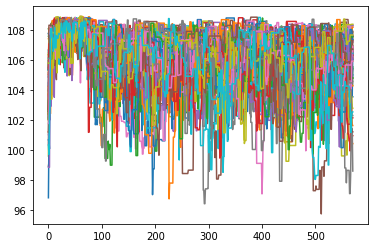

In [44]:
plt.plot(m.weights[30:]);

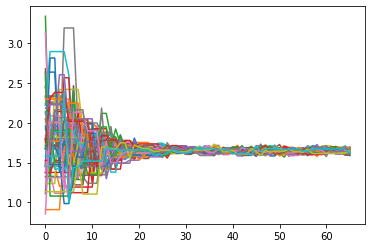

In [29]:
plt.plot(m.particles[10:, :, 3]);

In [46]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 108.83521881564515
"v_A": 2.157492,
"v_S": 1.639374,
"w": 0.358225,
"a_A": 1.637967,
"a_S": 0.902578,
"t0": 0.202736,


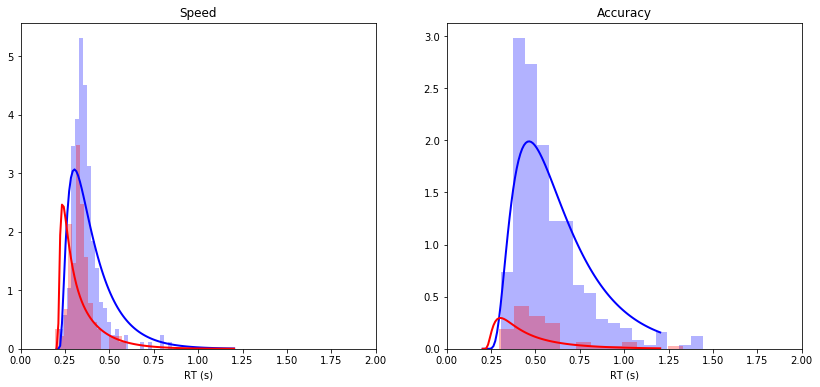

In [47]:
# set up new figure
plt.figure(figsize=(14,6))

# try different params!
plt.subplot(1,2,1)
cond='Speed'
run_wfpt(cond, v_mean=pp['v_S'], a=pp['a_S'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

plt.subplot(1,2,2)
cond='Accuracy'
run_wfpt(cond, v_mean=pp['v_A'], a=pp['a_A'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);


## Exploring the posterior

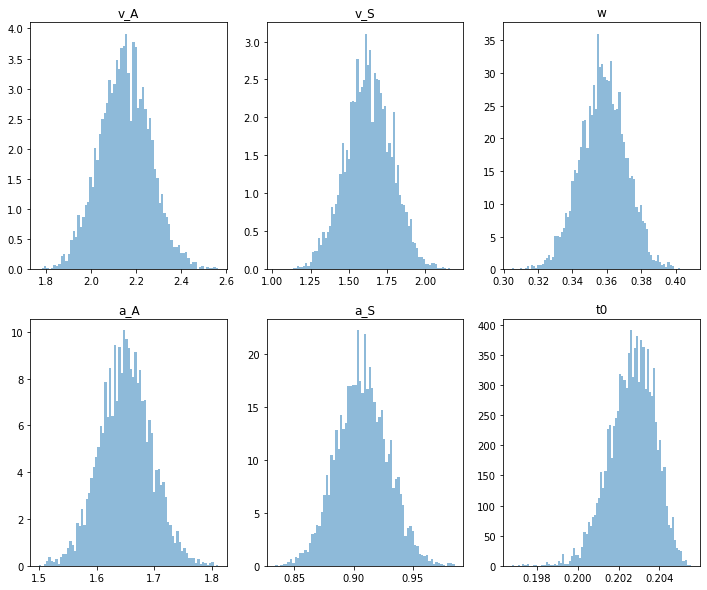

In [48]:
plt.figure(figsize=(12,10))
burnin=200
for i in range(len(params)):
    plt.subplot(2,3,i+1)
    plt.hist(m.particles[burnin:, :, i].flatten(), bins='auto', alpha=.5, density=True);
    plt.title(m.param_names[i])

In [49]:
m.particles.shape

(601, 60, 6)

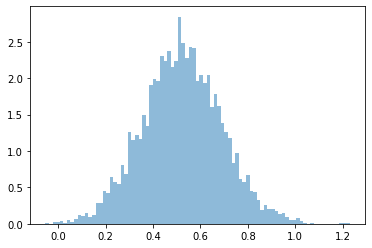

In [50]:
plt.hist(m.particles[burnin:, :, 0].flatten() - m.particles[burnin:, :, 1].flatten(),
         bins='auto', alpha=.5, density=True);

In [53]:
# save out model to an ArviZ Inference Dataset
daz_t = az.from_dict(**arviz_dict(m, burnin=200))
daz_t.posterior

<xarray.Dataset>
Dimensions:  (chain: 60, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    v_A      (chain, draw) float64 2.178 2.178 2.178 2.178 ... 2.409 2.359 2.359
    v_S      (chain, draw) float64 1.44 1.44 1.44 1.44 ... 1.78 1.931 1.931
    w        (chain, draw) float64 0.3804 0.3804 0.3804 ... 0.3556 0.3581 0.3581
    a_A      (chain, draw) float64 1.697 1.697 1.697 1.697 ... 1.672 1.657 1.657
    a_S      (chain, draw) float64 0.8961 0.8961 0.8961 ... 0.9467 0.9302 0.9302
    t0       (chain, draw) float64 0.2032 0.2032 0.2032 ... 0.2006 0.2015 0.2015
Attributes:
    created_at:  2020-03-19T18:25:38.168903

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/density.py:105: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(np.sqrt(cov))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/density.py:105: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(np.sqrt(cov))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/density.py:105: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(np.sqrt(cov))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/density.py:105: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(np.sqrt(cov))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/density.py:105: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(np.sqrt(cov))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/density.py:105: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(np.sqrt(cov))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/density.py:105: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(np.sqrt(cov))


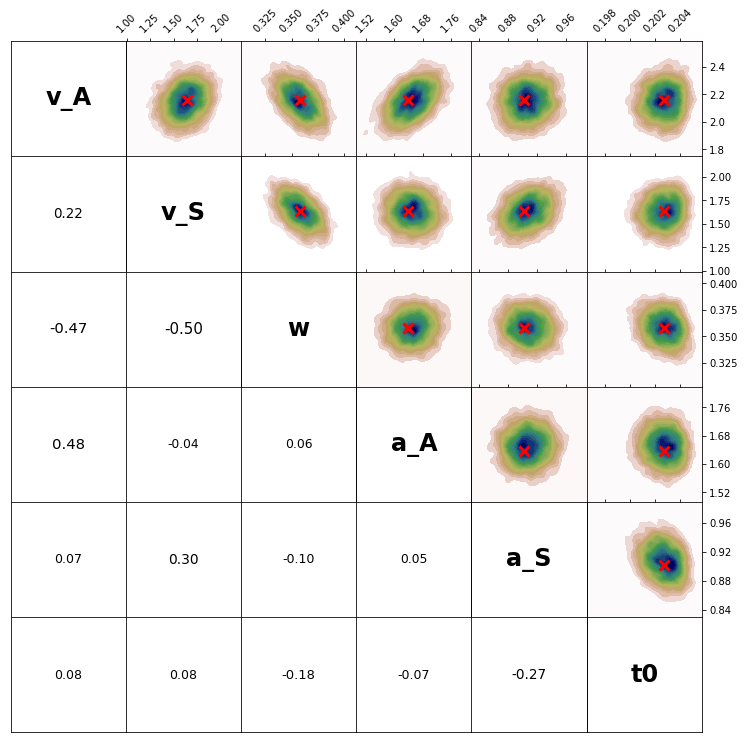

In [54]:
plt.figure(figsize=(12,12))

burnin = 200
joint_plot(m.particles, m.weights, burnin=burnin, 
           names=m.param_display_names, rot=45);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f590aef4410>,
      dtype=object)

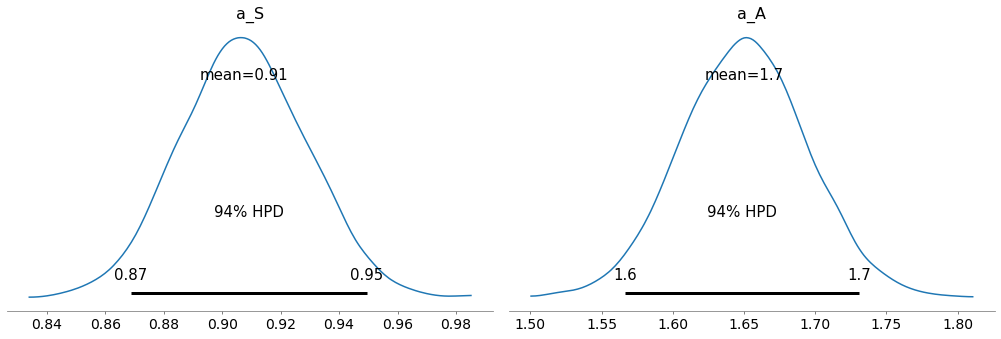

In [59]:
az.plot_posterior(daz_t, var_names=['a_S', 'a_A'])

In [61]:
# save results out to file
daz_t.to_netcdf('09_wfpt_results.nc')

'09_wfpt_results.nc'

In [62]:
# show how to read it back in
daz_t2 = az.from_netcdf('09_wfpt_results.nc')
daz_t2.posterior

<xarray.Dataset>
Dimensions:  (chain: 60, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    v_A      (chain, draw) float64 ...
    v_S      (chain, draw) float64 ...
    w        (chain, draw) float64 ...
    a_A      (chain, draw) float64 ...
    a_S      (chain, draw) float64 ...
    t0       (chain, draw) float64 ...
Attributes:
    created_at:  2020-03-19T18:25:38.168903